###**Modelo Solución y DecisionTreeClassifier**

####**Cargar librerías**

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Probamos otro tipo de escalador
from scipy import sparse
from sklearn.metrics import accuracy_score
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold

####**Carga del conjunto de datos Train y Test**

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "."  #Se establece la variable de entorno al directorio actual

In [3]:
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia  # Se descargan los archivos de la competencia directamente desde la API de Kaggle

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.16GB/s]


In [4]:
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip # Se descomprime el fichero para acceder al contenido

Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train = pd.read_csv('train.csv') # Carga del conjunto de datos de entrenamiento
test = pd.read_csv('test.csv')  # Carga del conjunto de datos de test para más adelante generar el csv

##**Limpieza de datos**


#####**Eliminación de las columnas**

En esta versión eliminamos solo unas cuantas columnas, porque están duplicadas (F_TIENEINTERNET.1) o en definitiva no son relevantes (E_PRIVADO_LIBERTAD).

In [6]:
del(train["ID"]) # No es relevante para el modelo, ya que no tiene mucha relación con el rendimiento ni aporta información predicitva
del(train["F_TIENEINTERNET.1"]) # Columna duplicada de 'F_TIENEINTERNET.1', se elimina para evitar redundancia
del(train["E_PRIVADO_LIBERTAD"]) # Tiene una proporción mínima de casos en una categoría, por lo tanto no es relevante
del(train["PERIODO_ACADEMICO"]) # Se elimina debido al desbalance de datos entre periodos.

del(test["F_TIENEINTERNET.1"])
del(test["E_PRIVADO_LIBERTAD"])
del(test["PERIODO_ACADEMICO"])

Revisamos la correlación entre los indicadores por medio de un gráfico.

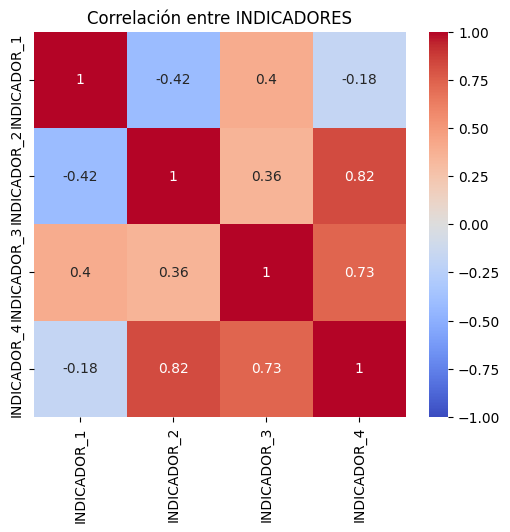

In [7]:
corr = train[["INDICADOR_1","INDICADOR_2","INDICADOR_3","INDICADOR_4"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre INDICADORES")
plt.show()

La matriz de correlación muestra que INDICADOR_2 y INDICADOR_4 tienen una correlación alta (0.82), lo cual indica información redundante. En este caso, eliminamos INDICADOR_4 del modelo.

In [8]:
df_train = train.drop(columns=["INDICADOR_4"])
df_test = test.drop(columns=["INDICADOR_4"])

Verificación de columnas restantes

In [9]:
# Reordenamos train para que sea consistente con test

otras = [c for c in df_train.columns if c != "RENDIMIENTO_GLOBAL"]
df_train = df_train[otras + ["RENDIMIENTO_GLOBAL"]]

# Validamos los cambios
print(df_train.columns)
print(df_test.columns)

Index(['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
       'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA',
       'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE',
       'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PAGOMATRICULAPROPIO',
       'F_TIENECOMPUTADOR', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2',
       'INDICADOR_3', 'RENDIMIENTO_GLOBAL'],
      dtype='object')
Index(['ID', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
       'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA',
       'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE',
       'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PAGOMATRICULAPROPIO',
       'F_TIENECOMPUTADOR', 'F_EDUCACIONMADRE', 'INDICADOR_1', 'INDICADOR_2',
       'INDICADOR_3'],
      dtype='object')


####**Tratamiento de Algunas Variables Categóricas Ordinales**



A diferencia de los otros preprocesados, en este realizamos el mapeo solo ciertas variables omitiendo otras como educación del padre y de la madre.

In [10]:
def codificar_ordinal(df, mapeos):
    # Aplica codificación ordinal a las columnas especificadas en 'mapeos'
    # cada categoría es reemplazada por un número según su jerarquía.
    df_copia = df.copy()
    for col, mapa in mapeos.items():
        if col in df_copia.columns:
            df_copia[col] = df_copia[col].map(mapa)

    return df_copia

In [11]:
# Mapeamos solo algunas columnas para convertirlas en númericas
mapeos_train = {
    'E_VALORMATRICULAUNIVERSIDAD': {
        'No pagó matrícula': 0,
        'Menos de 500 mil': 0.25,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Entre 4 millones y menos de 5.5 millones': 4.25,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'Más de 7 millones': 8
    },
    'E_HORASSEMANATRABAJA': {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    },
    'F_ESTRATOVIVIENDA': {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    },
    'RENDIMIENTO_GLOBAL': {
        'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3
    }
}

mapeos_test = {
    'E_VALORMATRICULAUNIVERSIDAD': {
        'No pagó matrícula': 0,
        'Menos de 500 mil': 0.25,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Entre 4 millones y menos de 5.5 millones': 4.25,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'Más de 7 millones': 8
    },
    'E_HORASSEMANATRABAJA': {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    },
    'F_ESTRATOVIVIENDA': {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
}

In [12]:
#Se aplica la codificación ordinal a las variables categóricas según los mapeos definidos
df_train_map = codificar_ordinal(df_train, mapeos_train)
df_test_map = codificar_ordinal(df_test, mapeos_test)

####**Reemplazo de Datos Faltantes**

Reemplazamos las columnas mapeadas anteriormente que tienen nulos por la media, moda y mediana.

In [13]:
col_Nanh = df_train_map.isna().sum()
col_Nanh[col_Nanh!=0]

,0
E_VALORMATRICULAUNIVERSIDAD,6287
E_HORASSEMANATRABAJA,30857
F_ESTRATOVIVIENDA,32137
F_TIENEINTERNET,26629
F_EDUCACIONPADRE,23178
F_TIENELAVADORA,39773
F_TIENEAUTOMOVIL,43623
E_PAGOMATRICULAPROPIO,6498
F_TIENECOMPUTADOR,38103
F_EDUCACIONMADRE,23664


In [14]:
df_train_map['E_VALORMATRICULAUNIVERSIDAD'] = df_train_map['E_VALORMATRICULAUNIVERSIDAD'].fillna(
    df_train_map['E_VALORMATRICULAUNIVERSIDAD'].mean()
)

df_train_map['F_ESTRATOVIVIENDA'] = df_train_map['F_ESTRATOVIVIENDA'].fillna(
    df_train_map['F_ESTRATOVIVIENDA'].mode()[0]
)

df_train_map['E_HORASSEMANATRABAJA'] = df_train_map['E_HORASSEMANATRABAJA'].fillna(
    df_train_map['E_HORASSEMANATRABAJA'].median()
)

df_test_map['E_VALORMATRICULAUNIVERSIDAD'] = df_test_map['E_VALORMATRICULAUNIVERSIDAD'].fillna(
    df_test_map['E_VALORMATRICULAUNIVERSIDAD'].mean()
)

df_test_map['F_ESTRATOVIVIENDA'] = df_test_map['F_ESTRATOVIVIENDA'].fillna(
    df_test_map['F_ESTRATOVIVIENDA'].mode()[0]
)

df_test_map['E_HORASSEMANATRABAJA'] = df_test_map['E_HORASSEMANATRABAJA'].fillna(
    df_test_map['E_HORASSEMANATRABAJA'].median()
)

Reemplazamos los valores nulos de las variables restantes por la categoría "missing".

In [15]:
df_train_map = df_train_map.fillna("missing")
df_test_map = df_test_map.fillna("missing")

#####**Codificación de Variables Categóricas con One Hot**

Se incluyeron variables adicionales en el proceso de transformación OneHot Encoding.

In [16]:
#Estas funciones permiten trasnformar las variables categóricas en formato One-Hot
def to_onehot(x): # Convierte una variable categórica a formato One Hot
    values = np.unique(x)
    r = np.r_[[np.argwhere(i == values)[0][0] for i in x]]
    onehot_sparse = sparse.csr_matrix(
        (np.ones(len(r)), (np.arange(len(r)), r)),
        shape=(len(r), len(values))
    )
    return onehot_sparse, values

# Reemplaza una columna por su versión One Hot
def replace_column_with_onehot(d, col):
    assert sum(d[col].isna()) == 0, "column must have no NaN values"
    k_sparse, values = to_onehot(d[col].values)
    k = pd.DataFrame.sparse.from_spmatrix(
        k_sparse,
        columns=["%s_%s" % (col, values[i]) for i in range(k_sparse.shape[1])],
        index=d.index
    )
    r = k.join(d)
    del (r[col])
    return r

# Aplica One-Hot Encoding a múltiples columnas categóricas
def aplicar_onehot_a_varias(df, columnas):
    df_datos = df.copy()
    for col in columnas:
        df_datos = replace_column_with_onehot(df_datos, col)
    return df_datos


In [17]:
df_train_onehot = aplicar_onehot_a_varias(
    df_train_map,
    [
        "F_TIENEINTERNET",
        "F_EDUCACIONPADRE",
        "F_EDUCACIONMADRE",
        "F_TIENELAVADORA",
        "F_TIENEAUTOMOVIL",
        "E_PAGOMATRICULAPROPIO",
        "F_TIENECOMPUTADOR",
        "E_PRGM_DEPARTAMENTO",
        "E_PRGM_ACADEMICO"
    ]
)  # Aplica One Hot a las variables categóricas seleccionadas

In [18]:
df_test_onehot = aplicar_onehot_a_varias(
    df_test_map,
    [
        "F_TIENEINTERNET",
        "F_EDUCACIONPADRE",
        "F_EDUCACIONMADRE",
        "F_TIENELAVADORA",
        "F_TIENEAUTOMOVIL",
        "E_PAGOMATRICULAPROPIO",
        "F_TIENECOMPUTADOR",
        "E_PRGM_DEPARTAMENTO",
        "E_PRGM_ACADEMICO"
    ]
)  # Aplica One Hot a las variables categóricas seleccionadas

####**Normalización de Columnas**

Se normalizaron todas las variables numéricas para homogenizar escalas

In [19]:
# Se crea el objeto escalador
escalar = StandardScaler()

# Columnas a normalizar
columnas_a_normalizar = [
    "E_VALORMATRICULAUNIVERSIDAD",
    "INDICADOR_1", "INDICADOR_2", "INDICADOR_3",
    "F_ESTRATOVIVIENDA",
    "E_HORASSEMANATRABAJA"
]

# Ajustar el escalador a los datos y transformar las columnas
df_train_onehot[columnas_a_normalizar] = escalar.fit_transform(df_train_onehot[columnas_a_normalizar])
df_test_onehot[columnas_a_normalizar] = escalar.fit_transform(df_test_onehot[columnas_a_normalizar])

In [20]:
df_train_final = df_train_onehot.copy()
df_test_final = df_test_onehot.copy()

###**Modelo DecisionTreeClassifier**

Se aplica un modelo de árbol de decisiones para predecir el rendimiento global. El modelo se entrena con una profundidad máxima definida en 5 y se evalúa calculando el accuracy.

In [26]:
# Variable objetivo
y = df_train_final["RENDIMIENTO_GLOBAL"]

# Predictoras
X = df_train_final.drop(columns=["RENDIMIENTO_GLOBAL"])

# Creamos el árbol de decisión
dt = DecisionTreeClassifier(max_depth=20)

# Entrenamiento sobre todo el dataset
dt.fit(X, y)

# Predicción sobre el mismo dataset
y_pred_train = dt.predict(X)

# Accuracy en entrenamiento
train_accuracy = accuracy_score(y, y_pred_train)
print("Accuracy en entrenamiento:", train_accuracy)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy en entrenamiento: 0.48659205776173287


####**Revisión del Accuracy con Datos de Train**

Se realiza una división de los datos en 70% para entrenamiento y 30% para prueba, y con estos conjuntos se evalúa el modelo.

In [27]:
# Modelo
dt = DecisionTreeClassifier(max_depth=20)

# Split
test_size = 0.3
val_size  = test_size / (1 - test_size)

print("Dimensiones:", X.shape, y.shape)
print("test size =", test_size)
print("val size  =", val_size)

Xtv, Xts, ytv, yts = train_test_split(
    X, y,
    test_size=test_size,
    stratify=y,
    random_state=7
)

print("Train:", Xtv.shape, "Test:", Xts.shape)

# Entrenar y predecir
dt.fit(Xtv, ytv)
y_pred = dt.predict(Xts)

# Accuracy
print("Accuracy en test:", accuracy_score(yts, y_pred))

Dimensiones: (692500, 1026) (692500,)
test size = 0.3
val size  = 0.4285714285714286
Train: (484750, 1026) Test: (207750, 1026)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy en test: 0.386589651022864


####**Técnicas de Validación Cruzada**

#####**Uso de ShuffleSplit**

Se utilizó validación cruzada con ShuffleSplit

In [28]:
# Modelo
estimator = DecisionTreeClassifier(max_depth=20)

# ShuffleSplit con 3 splits
cv = ShuffleSplit(n_splits=3, test_size=0.3)

scores = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy')

print("CV scores:", scores)
print("Mean ± std:", np.mean(scores), "+-", np.std(scores))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

CV scores: [0.38562214 0.386142   0.38676775]
Mean ± std: 0.3861772964300039 +- 0.00046835795240922394


####**Generación del CSV - Kaggle**

In [29]:
# Alinear columnas de test con las de train
# Se eliminan porque los datos de train no tienen información sobre esos programas académicos
X_test_aligned = df_test_final.reindex(columns=X.columns, fill_value=0)

# Generar predicciones
y_pred_num = dt.predict(X_test_aligned)

# Mapear nuevamente
num_to_label = {0:'bajo', 1:'medio-bajo', 2:'medio-alto', 3:'alto'}
y_pred_labels = [num_to_label[i] for i in y_pred_num]

# Guardar en CSV
resultado = pd.DataFrame({
    "ID": df_test_final["ID"],  # columna identificadora
    "RENDIMIENTO_GLOBAL": y_pred_labels
})

resultado.to_csv("Predicciones_test.csv", index=False)
print("Predicciones generadas")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Predicciones generadas
